In [2]:
import numpy as np

In [3]:
from dataclasses import dataclass
from solver.simple_hrl_solver import BaseSimulator
from typing import Union
import matplotlib.pyplot as plt

In [262]:
@dataclass
class MultipleRLPerceptronSimulator(BaseSimulator):
    num_task: int
    identical: bool

    def setup_train(self):
        self.lr_w = self.lr['lr_w']
        self.WT = np.random.normal(loc=0.0,
                                   scale=1.0,
                                   size=(self.num_task, self.num_task, self.input_dim))
        wt_norm = np.sqrt(np.einsum('ijk,ijk->ij', self.WT, self.WT)/ self.input_dim)
        
        for i in range(self.num_task):
            for j in range(self.num_task):
                self.WT[i,j] /= wt_norm[i,j]
        self.WS = np.random.normal(loc=0.0,
                                   scale=1.0,
                                   size=(self.num_task, self.num_task,  self.input_dim))*0.001
        #ws_norm = np.sqrt(np.einsum('ijk,ijk->ij', self.WS, self.WS)/ self.input_dim)
        #self.WS/=ws_norm[:,:,None]

    def setup_history(self, num_update):
        self.history = {
            'Q': np.zeros((num_update, self.num_task, self.num_task)),
            'R': np.zeros((num_update, self.num_task, self.num_task)),
            'P': np.zeros((num_update, self.num_task))
        }

    def update_history(self, history_index):
        Q = np.einsum('ijk,ijk->ij', self.WS, self.WS) / self.input_dim
        R = np.einsum('ijk,ijk->ij', self.WS, self.WT) / self.input_dim
        P = 1 - np.arccos(np.diag(R) / np.sqrt(np.diag(Q))) / np.pi

        self.history['Q'][history_index] = Q
        self.history['R'][history_index] = R
        self.history['P'][history_index] = P

    def step(self):
        if self.identical:
            x = np.random.normal(loc=0.0,
                                 scale=1.0,
                                 size=(1, self.input_dim, self.seq_len))
            x = np.repeat(x, self.num_task, axis=0)
        else:
            x = np.random.normal(loc=0.0,
                                 scale=1.0,
                                 size=(self.num_task, self.num_task, self.input_dim,
                                       self.seq_len))

        y, y_sign, y_hat, y_hat_sign = self.inference(x)
        #ws_norm = np.sqrt(np.einsum('ijk,ijk->ij', self.WS, self.WS)/ self.input_dim)
        for k in range(self.num_task):
            if (y_sign[k] == y_hat_sign[k]).all():
                dW = (1 / np.sqrt(self.input_dim) * y_sign[k] *
                      x[k]).mean(axis=-1)
                self.WS[k] += self.lr_w * dW
                #self.WS[k]/=ws_norm[k][:,None]
                
                

    def inference(self, x):

        y = np.einsum('ijk, ijkl->il',self.WT, x) / np.sqrt(self.input_dim)
        y_hat = np.einsum('ijk, ijkl->il',self.WS,x) / np.sqrt(self.input_dim)
        y_sign = np.sign(y)
        y_hat_sign = np.sign(y_hat)

        return y, y_sign, y_hat, y_hat_sign




@dataclass
class CompositionalTaskSimulator(BaseSimulator):
    num_task: int
    identical: bool
    WT: Union[None, np.array] = None
    WS: Union[None, np.array] = None
    VT: Union[None, np.array] = None
    VS: Union[None, np.array] = None
    V_norm: int = 0

    def setup_train(self):
        self.lr_wc = self.lr['lr_wc']
        self.lr_vc = self.lr['lr_vc']
        if self.WT is None:
            self.WT = np.random.normal(loc=0.0,
                                       scale=1.0,
                                       size=(self.num_task, self.num_task, self.input_dim))
        wt_norm = np.sqrt(np.einsum('ijk,ijk->ij', self.WT, self.WT)/ self.input_dim)
        
        for i in range(self.num_task):
            for j in range(self.num_task):
                self.WT[i,j] /= wt_norm[i,j]
                
        if self.WS is None:
            self.WS = np.random.normal(loc=0.0,
                                       scale=1.0,
                                       size=(self.num_task, self.num_task, self.input_dim))*0.001
        #ws_norm = np.sqrt(np.einsum('ijk,ijk->ij', self.WS, self.WS)/ self.input_dim)
        #self.WS/=ws_norm[:,:,None]
        if self.VT is None:
            self.VT = np.random.normal(loc=0.0, scale=1.0, size=(self.num_task))
        if self.VS is None:
            self.VS = np.random.normal(loc=0.0, scale=1.0, size=(self.num_task))
        self.VS /= np.linalg.norm(self.VS)
        self.S = np.einsum('ijk,ijk->ij', self.WT, self.WT) / self.input_dim

    def setup_history(self, num_update):
        self.history = {
            'Q': np.zeros((num_update, self.num_task, self.num_task)),
            'R': np.zeros((num_update, self.num_task, self.num_task)),
            'P': np.zeros((num_update, self.num_task)),
            'overlap': np.zeros((num_update, self.num_task)),
            'VS': np.zeros((num_update, self.num_task)),
            'VSVT': np.zeros((num_update, self.num_task)),
            'P_tilde': np.zeros((num_update)),
            'overlap_tilde': np.zeros((num_update))
        }

    def update_history(self, history_index):
        Q = np.einsum('ijk,ijk->ij', self.WS, self.WS) / self.input_dim
        R = np.einsum('ijk,ijk->ij', self.WT, self.WS) / self.input_dim
        overlap_task = np.diag(R) / np.sqrt(np.diag(Q))
        P = 1 - np.arccos(overlap_task) / np.pi
        if self.identical:
            norm_student = np.sqrt(
                np.sum([
                    self.VS[i] * self.VS[j] * Q[i][j]
                    for i in range(self.num_task)
                    for j in range(self.num_task)
                ]))

            norm_teacher = np.sqrt(
                np.sum([
                    self.VT[i] * self.VT[j] * self.S[i][j]
                    for i in range(self.num_task)
                    for j in range(self.num_task)
                ]))
            overlap = np.sum([
                self.VS[i] * self.VT[j] * R[i][j]
                for i in range(self.num_task)
                for j in range(self.num_task)
            ]) / norm_teacher / norm_student
        if not self.identical:
            norm_student = np.sqrt(
                np.sum([
                    self.VS[i] * self.VS[i] * Q[i][i]
                    for i in range(self.num_task)
                ]))

            norm_teacher = np.sqrt(
                np.sum([
                    self.VT[i] * self.VT[i] * self.S[i][i]
                    for i in range(self.num_task)
                ]))
            overlap = np.sum([
                self.VS[i] * self.VT[i] * R[i][i] for i in range(self.num_task)
            ]) / norm_teacher / norm_student

        P_tilde = 1 - np.arccos(overlap) / np.pi

        self.history['Q'][history_index] = Q
        self.history['R'][history_index] = R
        self.history['P'][history_index] = P
        self.history['overlap'][history_index] = overlap_task
        self.history['VS'][history_index] = self.VS
        self.history['P_tilde'][history_index] = P_tilde
        self.history['overlap_tilde'][history_index] = overlap
        self.history['VSVT'][history_index] = np.dot(
            self.VS, self.VT) / np.linalg.norm(self.VS) / np.linalg.norm(
                self.VT)

    def step(self):

        if self.identical:
            x = np.random.normal(loc=0.0,
                                 scale=1.0,
                                 size=(1, self.input_dim, self.seq_len))
            x = np.repeat(x, self.num_task, axis=0)
        else:
            x = np.random.normal(loc=0.0,
                                 scale=1.0,
                                 size=(self.num_task, self.num_task, self.input_dim,
                                       self.seq_len))

        (y, y_sign, y_hat,
         y_hat_sign), (y_tilde, y_tilde_hat, y_tilde_sign,
                       y_tilde_hat_sign) = self.inference(x)  #num_task*n_seq
        
        if (y_tilde_sign == y_tilde_hat_sign).all():
            dW = (1 / np.sqrt(self.input_dim) * y_tilde_hat_sign[:,None,None,None].T *
                  self.VS[:,None,None,None] * x).mean(axis=(-1))
            dV = (1 / self.input_dim * y_hat * y_tilde_hat_sign).mean(axis=-1)
            self.WS += self.lr_wc * dW
            self.VS += self.lr_vc * dV
            
            if self.V_norm != 0:
                self.VS *= np.sqrt(self.num_task) / np.linalg.norm(self.VS)
            else:
                self.VS /= np.linalg.norm(self.VS)
            
            #ws_norm = np.sqrt(np.einsum('ijk,ijk->ij', self.WS, self.WS)/ self.input_dim)
            #self.WS/=ws_norm[:,:,None]
           
               
    def inference(self, x):

        def single_task_inference(x):
            y = np.einsum('ijk, ijkl->il',self.WT, x) / np.sqrt(self.input_dim)
            y_hat = np.einsum('ijk, ijkl->il',self.WS, x) / np.sqrt(self.input_dim)
            y_sign = np.sign(y)
            y_hat_sign = np.sign(y_hat)

            return y, y_sign, y_hat, y_hat_sign

        y, y_sign, y_hat, y_hat_sign = single_task_inference(x)
        y_tilde = self.VT@y
        y_tilde_hat = self.VS@y_hat
        y_tilde_sign = np.sign(y_tilde)
        y_tilde_hat_sign = np.sign(y_tilde_hat)

        return (y, y_sign, y_hat, y_hat_sign), (y_tilde, y_tilde_hat,
                                                y_tilde_sign, y_tilde_hat_sign)



In [263]:
num_task = 3
input_dim = 200
seq_len = 4

In [264]:

m=MultipleRLPerceptronSimulator(input_dim = input_dim, seq_len = seq_len, num_task = num_task, identical = False )
m.train(num_iter=100000, update_frequency = 1000, lr = {'lr_w': .1})


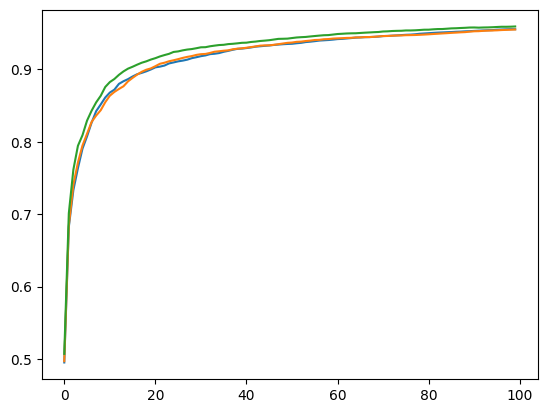

In [274]:
plt.plot(m.history['P'])

In [275]:
m_comp = CompositionalTaskSimulator(input_dim = input_dim, seq_len = seq_len, 
                                    num_task = num_task, VS=np.array([1.5, 0.5, 1.5]), VT = np.array([1,1,1]), identical = False)
m_comp.train(num_iter = 200000, update_frequency = 1000, lr = {'lr_wc':.1, 'lr_vc':.1})

In [276]:
m_comp.VS

array([0.10384305, 0.00441914, 0.99458388])

In [277]:
m_comp_pre = CompositionalTaskSimulator(input_dim = input_dim, seq_len = seq_len, 
                                    num_task = num_task, WT = m.WT, WS=m.WS, VS=np.array([1.5, 0.5, 1.5]), VT = np.array([1,1,1]), identical = False)
m_comp_pre.train(num_iter = 200000, update_frequency = 1000, lr = {'lr_wc':.1, 'lr_vc':.1})

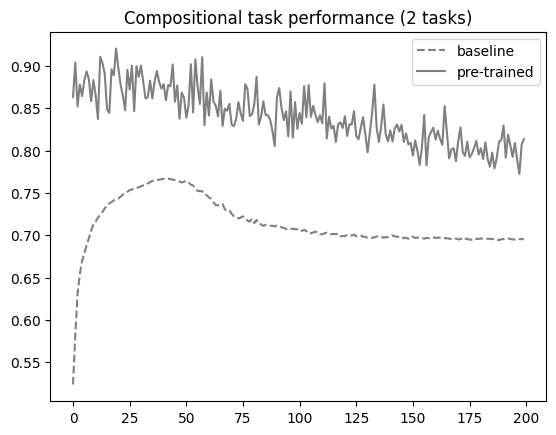

In [278]:
plt.plot(m_comp.history['P_tilde'], c='gray', ls = '--', label = 'baseline')
plt.plot(m_comp_pre.history['P_tilde'], c='gray', label = 'pre-trained')
plt.title('Compositional task performance (2 tasks)')
plt.legend()

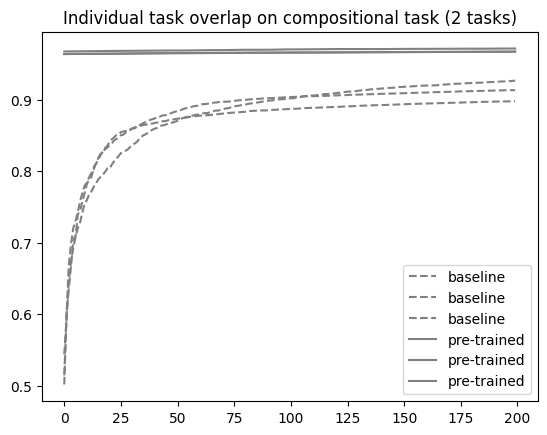

In [279]:
plt.plot(m_comp.history['P'], c = 'gray', ls = '--', label = 'baseline')
plt.plot(m_comp_pre.history['P'], c = 'gray', label = 'pre-trained')
plt.title('Individual task overlap on compositional task (2 tasks)')
plt.legend()

In [273]:
m_comp.VS

array([0.99764564, 0.00503042, 0.0683949 ])

In [207]:
num_task = 2
input_dim = 3
x = np.random.normal(loc=0.0,scale=1.0,size=(num_task, num_task,input_dim, seq_len))
wt = np.random.normal(loc=0.0,scale=1.0,size=(num_task, num_task, input_dim))
y=np.einsum('ijk, ijkl->il',wt,x)

In [210]:
x

array([[[[ 1.58665576,  0.08680177, -1.01545581, -0.35973693],
         [-1.77566943,  0.73279826,  0.90775625,  1.42816264],
         [ 0.80202925,  0.25581114, -0.14154947, -0.17654411]],

        [[ 1.640788  , -0.80184431,  0.78526726, -1.50654443],
         [-0.76880685, -0.86623844, -0.32963765,  1.31255293],
         [ 1.20226089,  0.71491991,  0.28007729, -0.07569665]]],


       [[[-0.57134924, -0.03434856,  0.54251434, -2.04777109],
         [-0.43368065, -0.72340781, -1.721818  , -0.27102699],
         [ 0.58953308, -0.83680603, -1.44488033, -2.36144194]],

        [[-0.82103883, -0.19123092, -0.11800232, -1.51289787],
         [-0.67921616,  0.2688099 ,  0.17589179, -1.25117238],
         [-0.75459949, -0.1069625 , -2.15624405,  0.37771988]]]])

In [224]:
y_tilde

array([-1.,  1., -1.,  1.])

In [208]:
y_tilde = np.sign(np.array([1,1])@y)

In [225]:
(abs(y_tilde[:,None,None,None]).T* np.array([1,1])[:,None,None,None] *x).mean(axis=-1)[0,0]

array([0.0745662 , 0.32326193, 0.1849367 ])

In [221]:
x[0,0].mean(axis=-1)

array([0.0745662 , 0.32326193, 0.1849367 ])

In [186]:
np.sum(wt[0,:,:]*x[0,:,:,0])

18.51960216305127

In [192]:
v = np.ones(num_task)

In [196]:
v@y

array([ 17.09995053,  14.34714941,  85.5218362 , -10.41601323])

In [197]:
y

array([[ 32.30255407, -22.2337257 ,   9.86860701,  52.22338369],
       [-15.20260354,  36.58087511,  75.6532292 , -62.63939692]])

In [184]:
np.sum(wt[0,:,:]*x[0,:,:,1])

-22.233725699974517

In [31]:
p = []
for i in range(100):
    x = np.random.normal(loc=0.0,
                                 scale=1.0,          size=(num_task,num_task,input_dim, seq_len))

    y, y_sign, y_hat, y_hat_sign=m.inference(x)
    p.append(y_sign[:,:] == y_hat_sign[:,:])

In [32]:
np.sum(p, axis = (0,2))/4

array([95.5 , 95.25, 95.  ])

In [181]:
p = []
p_ind = []
for i in range(100):
    x = np.random.normal(loc=0.0,
                                 scale=1.0,          size=(num_task,num_task,input_dim, seq_len))

    (y, y_sign, y_hat, y_hat_sign), (y_tilde, y_tilde_hat,
                                                y_tilde_sign, y_tilde_hat_sign)=m_comp.inference(x)
    p.append(np.all(y_tilde_sign == y_tilde_hat_sign))
    p_ind.append(y_sign[:,:] == y_hat_sign[:,:])

In [136]:
print(y_tilde_sign.shape)

(4,)


In [137]:
print(y.shape)

(3, 4)


In [138]:
print(x.shape)

(3, 3, 200, 4)


In [182]:
np.mean(p)

0.08

In [157]:
np.array(p_ind).shape

(100, 3, 4)

In [183]:
np.sum(p_ind, axis = (0,2))/4

array([49.75, 47.  , 53.25])

In [161]:
m_comp.VS

array([ 9.99999953e-01, -2.41459995e-04, -1.88303046e-04])

In [44]:
m_comp_pre.VS

array([0.84009956, 0.43761397, 0.32051013])

In [142]:
np.linalg.norm(m.WS[2,2])

31.656684155542706

In [113]:
np.divide(m.WS[0],ws_norm[0][:,None]).shape

(4, 1000)

In [98]:
m.WS[0]=ws_norm[0]

ValueError: could not broadcast input array from shape (4,) into shape (4,1000)

In [298]:
@dataclass
class MultipleRLPerceptronSimulator(BaseSimulator):
    num_task: int
    identical: bool

    def setup_train(self):
        self.lr_w = self.lr['lr_w']
        self.WT = np.random.normal(loc=0.0,
                                   scale=1.0,
                                   size=(self.num_task, self.input_dim))
        #self.WT /= np.sqrt((np.sum(self.WT @ self.WT.T)) / self.input_dim)
        self.WS = np.random.normal(loc=0.0,
                                   scale=1.0,
                                   size=(self.num_task, self.input_dim))

    def setup_history(self, num_update):
        self.history = {
            'Q': np.zeros((num_update, self.num_task, self.num_task)),
            'R': np.zeros((num_update, self.num_task, self.num_task)),
            'P': np.zeros((num_update, self.num_task))
        }

    def update_history(self, history_index):
        Q = self.WS @ self.WS.T / self.input_dim
        R = self.WS @ self.WT.T / self.input_dim
        P = 1 - np.arccos(np.diag(R) / np.sqrt(np.diag(Q))) / np.pi

        self.history['Q'][history_index] = Q
        self.history['R'][history_index] = R
        self.history['P'][history_index] = P

    def step(self):
        if self.identical:
            x = np.random.normal(loc=0.0,
                                 scale=1.0,
                                 size=(1, self.input_dim, self.seq_len))
            x = np.repeat(x, self.num_task, axis=0)
        else:
            x = np.random.normal(loc=0.0,
                                 scale=1.0,
                                 size=(self.num_task, self.input_dim,
                                       self.seq_len))

        y, y_sign, y_hat, y_hat_sign = self.inference(x)

        for k in range(self.num_task):
            if (y_sign[k] == y_hat_sign[k]).all():
                dW = (1 / np.sqrt(self.input_dim) * y_sign[k] *
                      x[k]).mean(axis=-1)
                self.WS[k] += self.lr_w * dW
                """
                self.WS[k] = np.divide(self.WS[k] * np.sqrt(self.input_dim),
                                       np.linalg.norm(self.WS[k]))
                """
                

    def inference(self, x):
        y = np.diagonal(self.WT @ x).T / np.sqrt(self.input_dim)
        y_hat = np.diagonal(self.WS @ x).T / np.sqrt(self.input_dim)
        y_sign = np.sign(y)
        y_hat_sign = np.sign(y_hat)

        return y, y_sign, y_hat, y_hat_sign

    
@dataclass
class CompositionalTaskSimulator(BaseSimulator):
    num_task: int
    identical: bool
    WT: Union[None, np.array] = None
    WS: Union[None, np.array] = None
    VT: Union[None, np.array] = None
    VS: Union[None, np.array] = None
    V_norm: int = 0

    def setup_train(self):
        self.lr_wc = self.lr['lr_wc']
        self.lr_vc = self.lr['lr_vc']
        if self.WT is None:
            self.WT = np.random.normal(loc=0.0,
                                       scale=1.0,
                                       size=(self.num_task, self.input_dim))
        for w in self.WT:
            w /= np.sqrt(w @ w.T / self.input_dim)
        if self.WS is None:
            self.WS = np.random.normal(loc=0.0,
                                       scale=1.0,
                                       size=(self.num_task, self.input_dim))
        if self.VT is None:
            self.VT = np.random.normal(loc=0.0, scale=1.0, size=(self.num_task))
        if self.VS is None:
            self.VS = np.random.normal(loc=0.0, scale=1.0, size=(self.num_task))

        self.S = self.WT @ self.WT.T / self.input_dim

    def setup_history(self, num_update):
        self.history = {
            'Q': np.zeros((num_update, self.num_task, self.num_task)),
            'R': np.zeros((num_update, self.num_task, self.num_task)),
            'P': np.zeros((num_update, self.num_task)),
            'overlap': np.zeros((num_update, self.num_task)),
            'VS': np.zeros((num_update, self.num_task)),
            'VSVT': np.zeros((num_update, self.num_task)),
            'P_tilde': np.zeros((num_update)),
            'overlap_tilde': np.zeros((num_update))
        }

    def update_history(self, history_index):
        Q = self.WS @ self.WS.T / self.input_dim
        R = self.WS @ self.WT.T / self.input_dim
        overlap_task = np.diagonal(R) / np.sqrt(np.diagonal(Q))
        P = 1 - np.arccos(overlap_task) / np.pi
        if self.identical:
            norm_student = np.sqrt(
                np.sum([
                    self.VS[i] * self.VS[j] * Q[i][j]
                    for i in range(self.num_task)
                    for j in range(self.num_task)
                ]))

            norm_teacher = np.sqrt(
                np.sum([
                    self.VT[i] * self.VT[j] * self.S[i][j]
                    for i in range(self.num_task)
                    for j in range(self.num_task)
                ]))
            overlap = np.sum([
                self.VS[i] * self.VT[j] * R[i][j]
                for i in range(self.num_task)
                for j in range(self.num_task)
            ]) / norm_teacher / norm_student
        if not self.identical:
            norm_student = np.sqrt(
                np.sum([
                    self.VS[i] * self.VS[i] * Q[i][i]
                    for i in range(self.num_task)
                ]))

            norm_teacher = np.sqrt(
                np.sum([
                    self.VT[i] * self.VT[i] * self.S[i][i]
                    for i in range(self.num_task)
                ]))
            overlap = np.sum([
                self.VS[i] * self.VT[i] * R[i][i] for i in range(self.num_task)
            ]) / norm_teacher / norm_student

        P_tilde = 1 - np.arccos(overlap) / np.pi

        self.history['Q'][history_index] = Q
        self.history['R'][history_index] = R
        self.history['P'][history_index] = P
        self.history['overlap'][history_index] = overlap_task
        self.history['VS'][history_index] = self.VS
        self.history['P_tilde'][history_index] = P_tilde
        self.history['overlap_tilde'][history_index] = overlap
        self.history['VSVT'][history_index] = np.dot(
            self.VS, self.VT) / np.linalg.norm(self.VS) / np.linalg.norm(
                self.VT)

    def step(self):

        if self.identical:
            x = np.random.normal(loc=0.0,
                                 scale=1.0,
                                 size=(1, self.input_dim, self.seq_len))
            x = np.repeat(x, self.num_task, axis=0)
        else:
            x = np.random.normal(loc=0.0,
                                 scale=1.0,
                                 size=(self.num_task, self.input_dim,
                                       self.seq_len))

        (y, y_sign, y_hat,
         y_hat_sign), (y_tilde, y_tilde_hat, y_tilde_sign,
                       y_tilde_hat_sign) = self.inference(x)  #num_task*n_seq
        if (y_tilde_sign == y_tilde_hat_sign).all():
            dW = (1 / np.sqrt(self.input_dim) * y_tilde_hat_sign[:, None].T *
                  self.VS[:, None] * x.swapaxes(0, 1)).mean(axis=-1).T
            dV = (1 / self.input_dim * y_hat * y_tilde_hat_sign).mean(axis=-1)
            self.WS += self.lr_wc * dW
            self.VS += self.lr_vc * dV
            """
            if self.V_norm != 0:
                self.VS *= np.sqrt(self.num_task) / np.linalg.norm(self.VS)
            else:
                self.VS /= np.linalg.norm(self.VS)
            
            self.WS = np.divide(self.WS * np.sqrt(self.input_dim),
                                np.linalg.norm(self.WS, axis=1)[:, None])
            """
    def inference(self, x):

        def single_task_inference(x):
            y = np.diagonal(self.WT @ x).T / np.sqrt(self.input_dim)
            y_hat = np.diagonal(self.WS @ x).T / np.sqrt(self.input_dim)
            y_sign = np.sign(y)
            y_hat_sign = np.sign(y_hat)

            return y, y_sign, y_hat, y_hat_sign

        y, y_sign, y_hat, y_hat_sign = single_task_inference(x)

        y_tilde = self.VT @ y
        y_tilde_hat = self.VS @ y_hat
        y_tilde_sign = np.sign(y_tilde)
        y_tilde_hat_sign = np.sign(y_tilde_hat)

        return (y, y_sign, y_hat, y_hat_sign), (y_tilde, y_tilde_hat,
                                                y_tilde_sign, y_tilde_hat_sign)



In [308]:

m=MultipleRLPerceptronSimulator(input_dim = input_dim, seq_len = seq_len, num_task = num_task, identical =False )
m.train(num_iter=100000, update_frequency = 1000, lr = {'lr_w': .1})

/tmp/ipykernel_1810583/1176765477.py:26: RuntimeWarning: invalid value encountered in arccos
  P = 1 - np.arccos(np.diag(R) / np.sqrt(np.diag(Q))) / np.pi


In [309]:
m_comp = CompositionalTaskSimulator(input_dim = input_dim, seq_len = seq_len, 
                                    num_task = num_task, VS=np.array([1.5, 0.5, 1.5]), VT = np.array([1,1,1]), identical = True)
m_comp.train(num_iter = 200000, update_frequency = 1000, lr = {'lr_wc':.1, 'lr_vc':.1})

In [310]:
m_comp_pre = CompositionalTaskSimulator(input_dim = input_dim, seq_len = seq_len, 
                                    num_task = num_task, WT = m.WT, WS = m.WS, VS=np.array([1.5, 0.5, 1.5]), VT = np.array([1,1,1]), identical = True)
m_comp_pre.train(num_iter = 200000, update_frequency = 1000, lr = {'lr_wc':.1, 'lr_vc':.1})

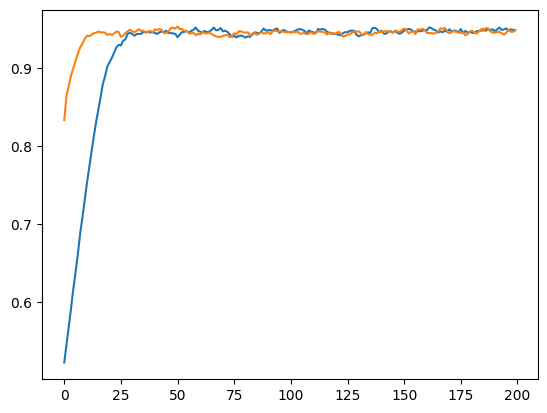

In [311]:
plt.plot(m_comp.history['P_tilde'])
plt.plot(m_comp_pre.history['P_tilde'])

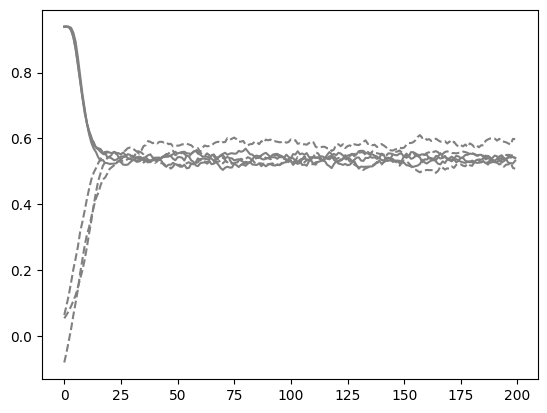

In [313]:
plt.plot(m_comp.history['overlap'], c= 'gray', ls = '--')
plt.plot(m_comp_pre.history['overlap'], c= 'gray')

In [291]:
p = []
p_ind = []
for i in range(100):
    x = np.random.normal(loc=0.0,
                                 scale=1.0,
                                 size=(1, m_comp.input_dim, m_comp.seq_len))
    x = np.repeat(x, m_comp.num_task, axis=0)

    (y, y_sign, y_hat, y_hat_sign), (y_tilde, y_tilde_hat,
                                                y_tilde_sign, y_tilde_hat_sign)=m_comp.inference(x)
    p.append(np.all(y_tilde_sign == y_tilde_hat_sign))
    p_ind.append(y_sign[:,:] == y_hat_sign[:,:])

In [296]:
np.mean(p_ind, axis=(0,2))

array([0.6375, 0.7   , 0.69  ])

In [297]:
m_comp.VS

array([5.04644448e+27, 1.65974607e+27, 5.35039500e+27])